In [1]:
import gym
import copy
import numpy as np
import time
import sys 
import torch
sys.path.append("MCTS") 
from monteCarlo import MCTree
import tools
from tools import get_args, registration_envs
import matplotlib.pyplot as plt
from network import nmodel

pretrained_models/PCT_setting1.pt
Loading pre-train upper model pretrained_models/PCT_setting1.pt
Pre-train model loaded! pretrained_models/PCT_setting1.pt


In [2]:
registration_envs()
args = get_args()
env = gym.make(args.id,
               setting = args.setting,
               item_set = args.item_size_set,
               container_size=args.container_size,
               data_name=args.dataset_path,
               load_test_data=args.load_dataset,
               internal_node_holder = args.internal_node_holder,
               leaf_node_holder = args.leaf_node_holder,
               LNES = args.lnes,
               shuffle=args.shuffle,
               sample_from_distribution=args.sample_from_distribution,
               sample_left_bound=args.sample_left_bound,
               sample_right_bound=args.sample_right_bound
               )
if args.no_cuda:
    device = torch.device('cpu')
else:
    device = torch.device('cuda', args.device)
    torch.cuda.set_device(args.device)
# nmodel = nnModel('pretrained_models/PCT_setting1.pt', args)

load data set successfully!
name: ./cut_22.pt


/root/anaconda3/envs/intelcup/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
def testMCTS(box_size_list, env, obser, simulation_times, search_depth, rollout_length):
    sim_env = copy.deepcopy(env)
    size_idx = len(box_size_list)
    action_list = []
    box_size_distribution = dict()
    box_num = 0
    sum_reward = 0
    # print("length: ", size_idx)
    
    mctree = MCTree(sim_env, obser, box_size_list, search_depth=search_depth, rollout_length=rollout_length)
    while True:
        # show some information
        # print(box_size_list[:10])
        # print(sim_env.space.plain)
        # MCTS simulation
        pl = mctree.get_policy(simulation_times, zeta=1e-5)
        action = mctree.sample_action(pl)
        
        assert sim_env.next_box == box_size_list[0]
        obser, r, done, dt = sim_env.step(action, 'testMCTS')
        sum_reward += r
        if done:
            dt['reward'] = sum_reward
            # print('---------------------')
            # print(dt)
            # print('---------------------')
            # print(action_list)
            # print('---------------------')
            # print(sim_env.space.plain)
            # print('---------------------')
            for (key, value) in box_size_distribution.items():
                box_size_distribution[key] = value / box_num
            # print(box_size_distribution)
            # print('---------------------')
            return [dt['ratio'], dt['counter'], dt['reward']]

        # fetch new box    
        assert size_idx <= len(env.box_creator.box_list)
        next_box = copy.deepcopy(env.box_creator.box_list[size_idx])
        size_idx += 1
        # update dis
        # tribution
        box_num += 1
        new_put_box = tuple(box_size_list[0])
        if new_put_box not in box_size_distribution:
            box_size_distribution[new_put_box] = 0
        box_size_distribution[new_put_box] += 1
        # update action
        action_list.append(action)
        # to next node
        mctree.succeed(action, next_box, obser)
def testPCT(env, obser, factor = 1):
    eval_envs = copy.deepcopy(env)
    PCT_policy = nmodel.PCT_policy
    obs = copy.deepcopy(obser)
    obs = torch.FloatTensor(obs).to(device).unsqueeze(dim=0)
    all_nodes, leaf_nodes = tools.get_leaf_nodes_with_factor(obs, args.num_processes,
                                                             args.internal_node_holder, args.leaf_node_holder)
    batchX = torch.arange(args.num_processes)
    episode_ratio = []
    episode_length = []
    
    while True:
        with torch.no_grad():
            selectedlogProb, selectedIdx, policy_dist_entropy, value = PCT_policy(all_nodes, True, normFactor = factor)        
        selected_leaf_node = leaf_nodes[batchX, selectedIdx.squeeze()]
        items = eval_envs.packed
        obs, reward, done, infos = eval_envs.step(selected_leaf_node.cpu().numpy()[0][0:6], 'testPCT')

        if done:
            return [infos['ratio'], infos['counter'], infos['reward']]

        obs = torch.FloatTensor(obs).to(device).unsqueeze(dim=0)
        all_nodes, leaf_nodes = tools.get_leaf_nodes_with_factor(obs, args.num_processes,
                                                                 args.internal_node_holder, args.leaf_node_holder)
        all_nodes, leaf_nodes = all_nodes.to(device), leaf_nodes.to(device)

def compare_test(env, obser, args_list, K, times=5):
    result = {'MCTS':[],'PCT':[]}
    print("Case number: %d"%times)
    for i in range(times):
        print('Case %d' % (i+1))
        
        next_box_size_list = env.box_creator.preview(1000)
         
        print('//////////////////////////////////////////////////')
        
        start = time.time()
        ratio, counter, reward = testMCTS(next_box_size_list[:K], env, obser, *args_list)
        end = time.time()
        result['MCTS'].append([ratio, counter, reward, end-start])
        print('mcts done ', ratio)
        
        start = time.time()
        ratio, counter, reward = testPCT(env, obser, args.normFactor)
        end = time.time()
        result['PCT'].append([ratio, counter, reward, end-start])  
        print('pct done ', ratio)

        print('//////////////////////////////////////////////////')
    for (key, value) in result.items():
        result[key] = np.array(value)
    return result

In [ ]:
args_list = [100, None, -1]
# args_list.append([1,0,0])
# args_list.append([400, 1, -1])
# args_list.append([400, None, -1])
# args_list.append([100, None, -1])

epoch = 10
results = {}
obser = env.reset()
for K in range(2,9):
    results[f'epoch={epoch}_K={K}'] = compare_test(env, obser, args_list, K, epoch)

Case number: 10
Case 1
//////////////////////////////////////////////////
cost time 33.44631100000015
terminated node: 0
reached depth: 1
reused simulation times: 99
children node number: 11
cost time 32.440423999999894
terminated node: 0
reached depth: 1
reused simulation times: 90
children node number: 40
cost time 32.42262000000028
terminated node: 0
reached depth: 1
reused simulation times: 100
children node number: 50
cost time 33.688658999999916
terminated node: 0
reached depth: 1
reused simulation times: 51
children node number: 46
cost time 33.69561399999975
terminated node: 0
reached depth: 1
reused simulation times: 55
children node number: 50
cost time 33.213410999999724
terminated node: 0
reached depth: 1
reused simulation times: 84
children node number: 50
cost time 35.46471100000008
terminated node: 0
reached depth: 1
reused simulation times: 76
children node number: 50
cost time 32.98155999999972
terminated node: 0
reached depth: 1
reused simulation times: 51
children no

In [7]:
def draw_img(result, msg, t):
    labels = ['ratio', 'counter', 'reward', 'time']
    means_mcts = result['MCTS'].mean(axis=-2)
    means_mcts[0]=float("%.2f" % (100 * means_mcts[0]))
    means_mcts[1]=float("%.2f" % (means_mcts[1]))
    means_mcts[2]=float("%.2f" % (means_mcts[2]))
    means_mcts[3]=float("%.2f" % (means_mcts[3]))
    means_pct = result['PCT'].mean(axis=-2)
    means_pct[0]=float("%.2f" % (100 * means_pct[0]))
    means_pct[1]=float("%.2f" % (means_pct[1]))
    means_pct[2]=float("%.2f" % (means_pct[2]))
    means_pct[3]=float("%.2f" % (means_pct[3]))
    plt.rcParams['font.family'] = ['Times New Roman']
    fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=200)
    labels = labels
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    label_font = {
        'weight':'bold',
        'size':14,
        'family':'simsun'
    }

    rects1 = ax.bar(x - width/2, means_mcts, width, label='MCTS',ec='k',color='white', lw=.8, hatch='...')
    rects2 = ax.bar(x + width/2 + .05, means_pct, width, label='PCT',ec='k',color='white', lw=.8, hatch='***')

    ax.tick_params(which='major',direction='in',length=5,width=1.5,labelsize=11,bottom=False)
    ax.tick_params(axis='x',labelsize=11,bottom=False,labelrotation=15)
    ax.set_xticks(x)
    ax.set_ylim(ymin = 0,ymax = 100)
    ax.set_yticks(np.arange(0,100,200))

    ax.set_ylabel('',fontdict=label_font)
    ax.set_xticklabels(labels,fontdict=label_font)
    #ax.legend(markerscale=10,fontsize=12,prop=legend_font)
    ax.legend(markerscale=10,fontsize=12)
    ax.text(.03,.93,msg,transform = ax.transAxes,zorder=4)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    timeStr = t + '-' + msg
    plt.savefig("img/"+timeStr+".jpg")

In [8]:
def draw_img_line(results,t):
    #设置自变量的范围和个数
    x , ratio, time= [], [], []
    for (msg,result) in results.items():
        x.append(msg[-1])
        ratio.append(float("%.2f" % (100 * result['MCTS'].mean(axis=-2)[0])))
        time.append(float("%.2f" % (result['MCTS'].mean(axis=-2)[3])))
        
    fig,ax=plt.subplots(figsize=(6,4), dpi=200)
    #画图
    ax.plot(x,ratio, label='ratio', linestyle='-', marker='*',  markersize='10')
    #设置坐标轴
    #ax.set_xlim(0, 9.5)
    #ax.set_ylim(0, 1.4)
    ax.set_xlabel('K', fontsize=13)
    ax.set_ylabel('value', fontsize=13)
    #设置刻度
    ax.tick_params(axis='both', labelsize=11)
    #显示网格
    #ax.grid(True, linestyle='-.')
    ax.yaxis.grid(True, linestyle='-.')
    #添加图例
    legend = ax.legend(loc='best')

    plt.show()
    plt.savefig("img/"+ t + '-' + 'ratio' +".jpg")
    
    fig,ax=plt.subplots(figsize=(6,4), dpi=200)
    #画图
    ax.plot(x,time, label='time', linestyle='--', marker='x', markersize='10')
    #设置坐标轴
    #ax.set_xlim(0, 9.5)
    #ax.set_ylim(0, 1.4)
    ax.set_xlabel('K', fontsize=13)
    ax.set_ylabel('value', fontsize=13)
    #设置刻度
    ax.tick_params(axis='both', labelsize=11)
    #显示网格
    #ax.grid(True, linestyle='-.')
    ax.yaxis.grid(True, linestyle='-.')
    #添加图例
    legend = ax.legend(loc='best')

    plt.show()
    plt.savefig("img/"+ t + '-' + 'time' +".jpg")

findfont: Font family ['simsun'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


**************************************************
epoch=1_K=5
//////////////////////////////////////////////////
MCTS
ratio [0.884]
counter [21.]
reward [8.84]
time [989.75221419]
mean [8.84000000e-01 2.10000000e+01 8.84000000e+00 9.89752214e+02]
avg_time_per_item 47.131057818730675
//////////////////////////////////////////////////
//////////////////////////////////////////////////
PCT
ratio [0.854]
counter [20.]
reward [8.54]
time [0.7231524]
mean [ 0.854     20.         8.54       0.7231524]
avg_time_per_item 0.036157619953155515
//////////////////////////////////////////////////
**************************************************
**************************************************
epoch=1_K=8
//////////////////////////////////////////////////
MCTS
ratio [0.884]
counter [21.]
reward [8.84]
time [1169.36574507]
mean [8.84000000e-01 2.10000000e+01 8.84000000e+00 1.16936575e+03]
avg_time_per_item 55.68408309845697
//////////////////////////////////////////////////
//////////////////////

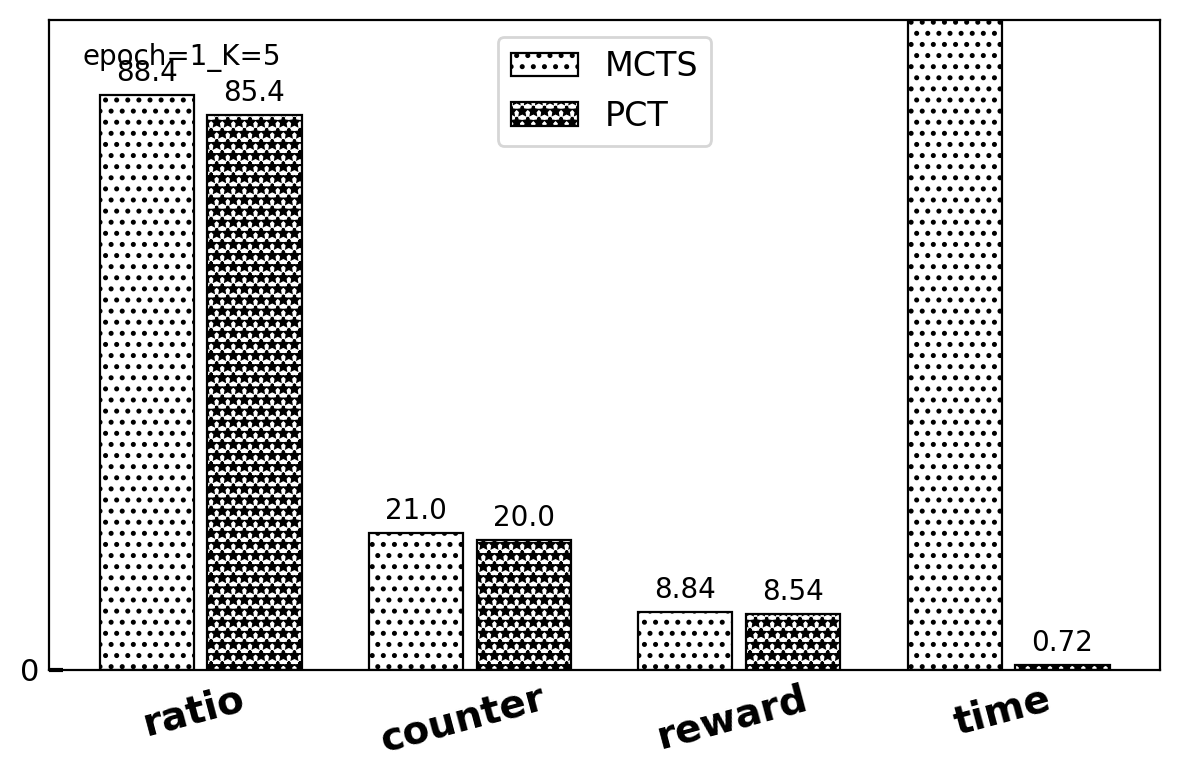

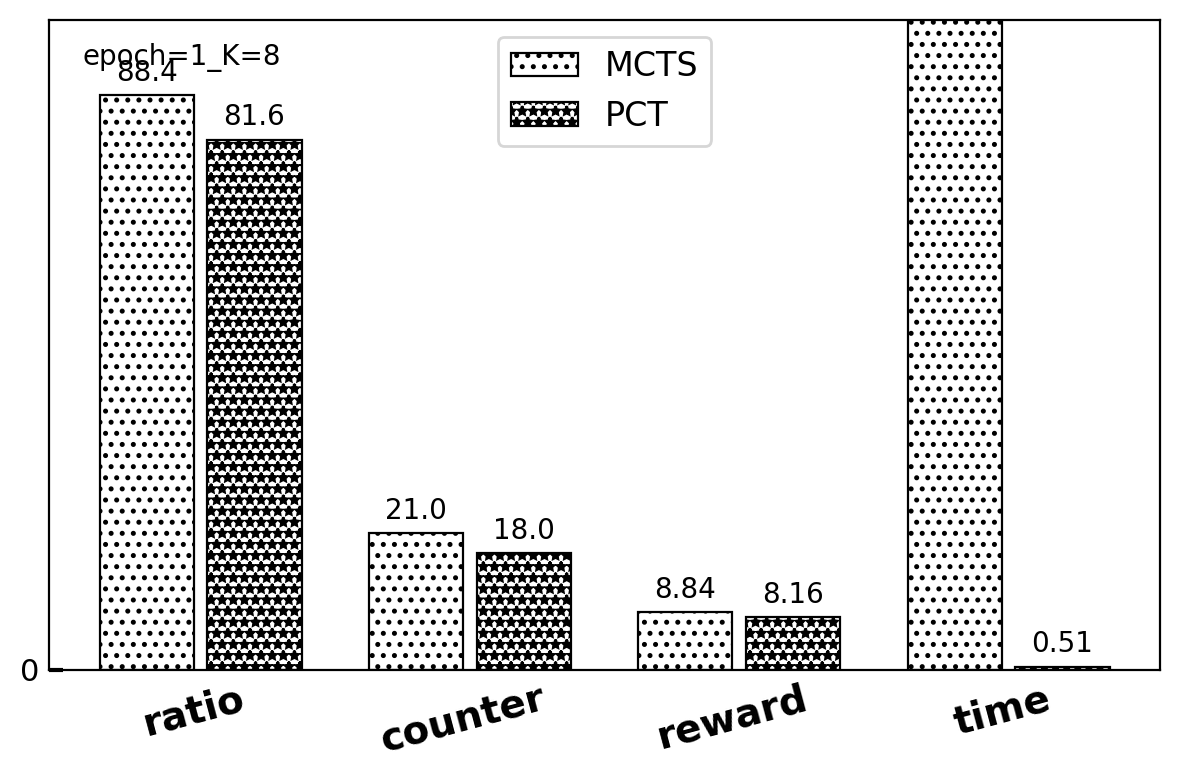

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


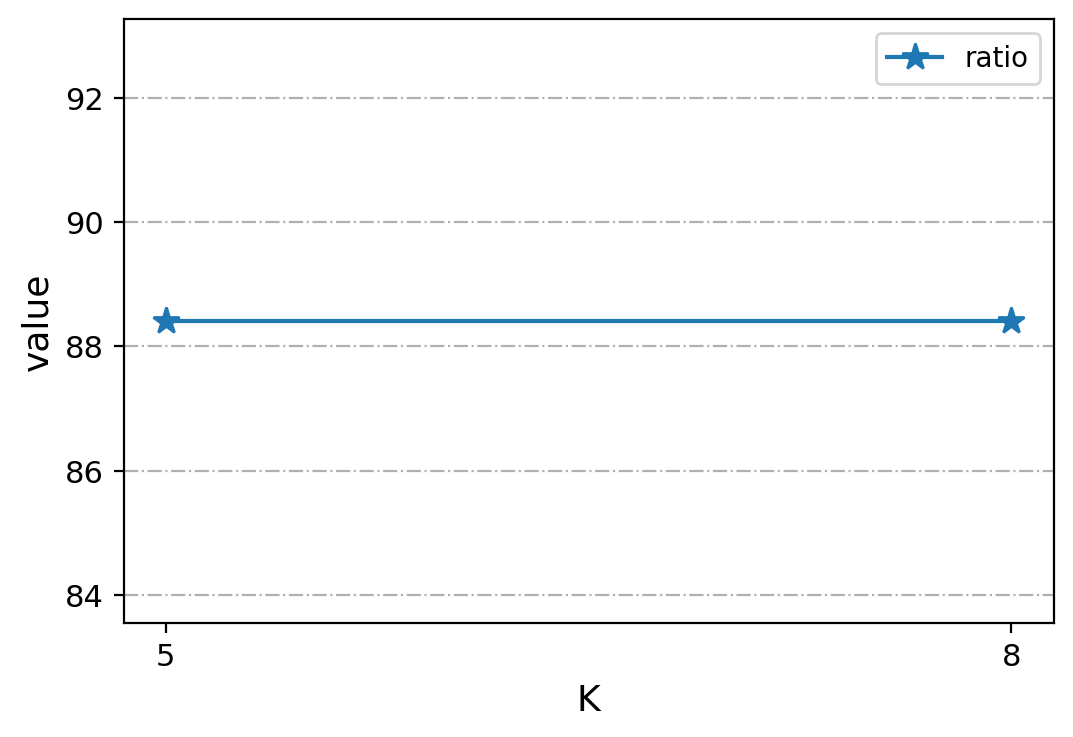

<Figure size 432x288 with 0 Axes>

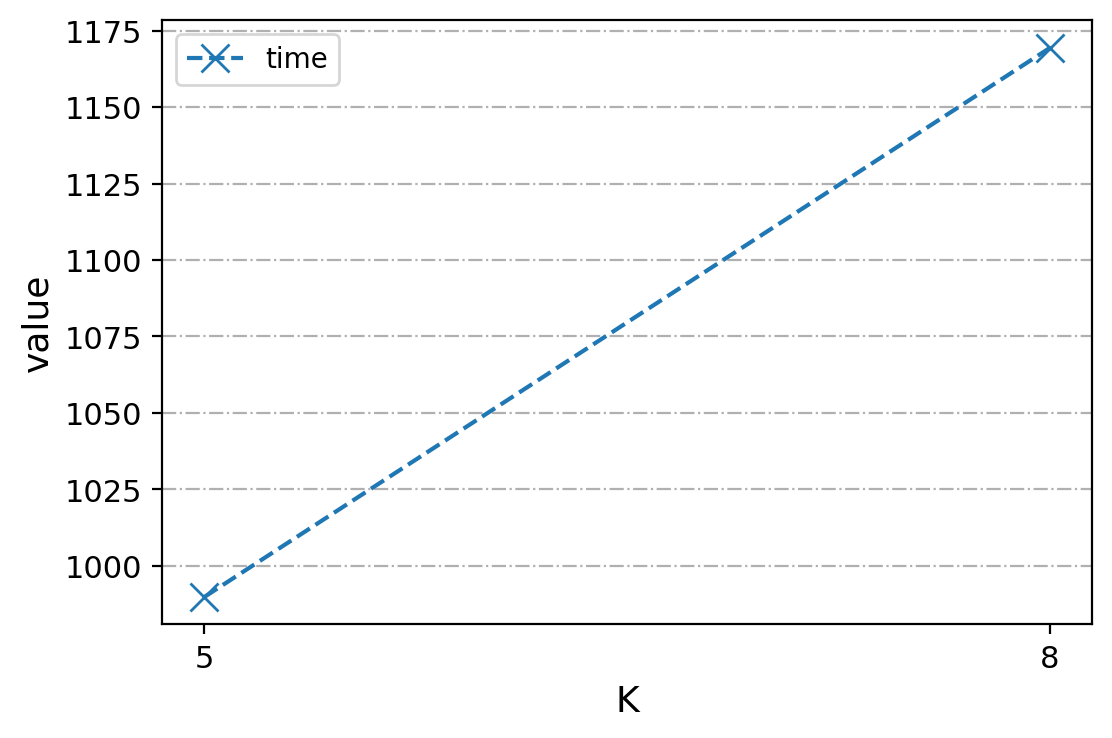

<Figure size 432x288 with 0 Axes>

In [9]:
t = time.strftime('%Y.%m.%d-%H-%M-%S', time.localtime(time.time()))
for (msg,result) in results.items():
    print('**************************************************')
    print(msg)
    for (key, value) in result.items():
        print('//////////////////////////////////////////////////')
        print(key)
        print('ratio', value[:, 0])
        print('counter',value[:, 1])
        print('reward',value[:, 2])
        print('time',value[:, 3])
        meanv = value.mean(axis=-2)
        print('mean',meanv)
        print("avg_time_per_item", meanv[-1]/meanv[1])
        # print(value.var(axis=-2))
        print('//////////////////////////////////////////////////')
    draw_img(result, msg, t)
    print('**************************************************')
draw_img_line(results, t)